![MOSEK ApS](https://www.mosek.com/static/images/branding/webgraphmoseklogocolor.png )

Smallest sphere enclosing a set of points.
===========================

The aim of this tutorial is two-fold

1. Demostrate how to write a conic quadratic model in `Fusion` in a very simple and compact way.
2. Show how and way the dual formulation may solved more efficiently.


Our problem is the defined as:

**Find the smallest sphere that encloses a set of** $k$ **points** $p_i \in \mathbb{R}^n$. 

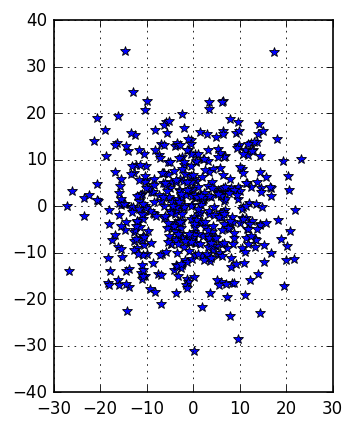

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

def plot_points(p, p0=[], r0=0.):
    n,k= len(p0), len(p)
    
    plt.rc('savefig',dpi=120)

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([ p[i][0] for i in range(k)], [ p[i][1] for i in range(k)], 'b*')
    
    if len(p0)>0:
        ax.plot(  p0[0],p0[1], 'r.')
        ax.add_patch( mpatches.Circle( p0,  r0 ,  fc="w", ec="r", lw=1.5) )
    plt.grid()
    plt.show()

n = 2
k = 500

p=  [ [random.gauss(0.,10.) for nn in range(n)] for kk in range(k)]

plot_points(p)

The problem boils down to determine the sphere center $p_0\in \mathbb{R}^n$ and its radius $r_0\geq 0$, i.e.


\begin{equation}
  \begin{aligned}
\min \max_{i=1,\dots,k} \| p_0 - p_i\|_2 \\
  \end{aligned}
\end{equation}

The maximum in the objective function can be easily, i.e.

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& r_0 \geq \| p_0 - p_i\|_2 ,& \quad & i=1,\ldots,k\\
\end{aligned}
\end{equation}

The SOCP formulation reads

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& \left[r_0,p_0 - p_i\right] \in Q^{(n+1)}, & \quad & i=1,\ldots,k.
\end{aligned}
\end{equation}

Before defining the constraints, we note that we can write


\begin{equation}
R_0 = \left( \begin{array}{c} r_0   \\ \vdots \\ r_0   \end{array} \right) \in \mathbb{R}^k          , \quad
P_0 = \left( \begin{array}{c} p_0^T \\ \vdots \\ p_0^T \end{array} \right) \in \mathbb{R}^{k\times n}, \quad
P   = \left( \begin{array}{c} p_1^T \\ \vdots \\ p_k^T \end{array} \right) \in \mathbb{R}^{k\times n}.
\end{equation}

so that 

\begin{equation}
\left[r_0,p_i - p_0\right] \in Q^{(n+1)},  \quad  i=1,\ldots,k.
\end{equation}

can be compactly expressed as 

\begin{equation}
\left[ R_0,P_0-P\right] \in \Pi Q^{(n+1)},
\end{equation}

that means, with a little abuse of notation, that each rows belongs to a quadratic cone of dimension $n+1$.


Now we are ready for a compact implementation in `Fusion`:

In [2]:
from mosek.fusion import *
import mosek as msk


def primal_problem(P):

    print(msk.Env.getversion())
    
    k= len(P)
    if k==0: return -1,[]

    n= len(P[0])
    
    with Model("minimal sphere enclosing a set of points - primal") as M:

        r0 = M.variable(1    , Domain.greaterThan(0.))
        p0 = M.variable([1,n], Domain.unbounded())

        R0 = Var.repeat(r0,k)
        P0 = Var.repeat(p0,k)
       
        M.constraint( Expr.hstack( R0, Expr.sub(P0 , P) ), Domain.inQCone())

        M.objective(ObjectiveSense.Minimize, r0)
        M.setLogHandler(open('logp','wt'))

        M.solve()

        return r0.level()[0], p0.level()
           

We will also store the solver output in a file to use it later on. And then just solve the problem.

In [3]:
r0,p0 = primal_problem(p)

print ("r0^* = ", r0)
print ("p0^* = ", p0)

(8, 0, 0, 48)
('r0^* = ', 34.277010059679036)
('p0^* = ', array([ 0.9775514 ,  3.05181728]))


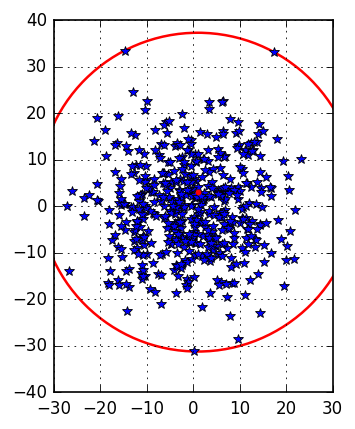

In [4]:
plot_points(p,p0,r0)

Dual Formulation 
-----------------------

The dual problem can be determined in few steps following basic rules. Introducing dual variables

\begin{equation}
 Y = \left( \begin{array}{c} y_1^T\\ \vdots \\y_k  \end{array}\right), \quad z = \left( \begin{array}{c} z_1\\ \vdots \\z_k  \end{array}\right), 
\end{equation}

the dual is:

\begin{aligned}
    \max & \left\langle P, Y \right\rangle \\
    & e_k^T z = 1\\
    & Y^T e_k = \mathbf{0}_n \\
    & \left[z_i , y_i\right] \in \mathcal{Q}^{n+1}\\
    & z_i\in \mathbb{R}, y_i\in \mathbb{R}^n,
\end{aligned}

where $e_k\in \mathbb{R}^k$ is a vector of all ones.

The ``Fusion`` code is the following:


In [5]:
def dual_problem(P):
        
    k= len(P)
    if k==0: return -1,[]

    n= len(P[0])
    
    with Model("minimal sphere enclosing a set of points - dual") as M:
  
        Y= M.variable([k,n], Domain.unbounded())
        z= M.variable(k    , Domain.unbounded())
                    
        M.constraint(Expr.sum(z), Domain.equalsTo(1.) )
        
        e= [1.0 for i in range(k)]
        
        M.constraint(Expr.mul(Y.transpose(), Matrix.ones(k,1)), Domain.equalsTo(0.) )

        M.constraint( Var.hstack(z,Y), Domain.inQCone())
        
        M.objective( ObjectiveSense.Maximize, Expr.dot( P, Y )) 
  
        M.setLogHandler(open('logd','wt'))

        M.solve()
    
        return 
        
dual_problem(p)

Looking at the solver output for the primal and dual implementation we get

In [6]:
!tail  logp

11  4.7e-06  2.8e-04  1.9e-05  1.01e+00   3.429062907e+01   3.430435587e+01   5.6e-07  0.01  
12  1.3e-06  7.5e-05  1.1e-05  1.00e+00   3.427957004e+01   3.428275209e+01   1.5e-07  0.01  
13  2.2e-07  1.3e-05  4.8e-06  1.00e+00   3.427737473e+01   3.427786148e+01   2.7e-08  0.01  
14  2.1e-08  1.2e-06  1.6e-06  1.00e+00   3.427703453e+01   3.427707456e+01   2.5e-09  0.01  
15  2.8e-09  1.7e-07  5.7e-07  1.00e+00   3.427701143e+01   3.427701671e+01   3.3e-10  0.01  
16  5.3e-10  3.2e-08  2.7e-07  1.00e+00   3.427701016e+01   3.427701104e+01   6.3e-11  0.01  
17  3.1e-11  1.4e-09  4.5e-08  1.00e+00   3.427701006e+01   3.427701009e+01   2.7e-12  0.01  
Interior-point optimizer terminated. Time: 0.01. 

Optimizer terminated. Time: 0.10    


In [7]:
!tail logd

11  2.8e-04  4.7e-06  1.9e-05  1.01e+00   3.430435567e+01   3.429062880e+01   5.6e-07  0.01  
12  7.5e-05  1.3e-06  1.1e-05  1.00e+00   3.428275207e+01   3.427956999e+01   1.5e-07  0.01  
13  1.3e-05  2.2e-07  4.8e-06  1.00e+00   3.427786147e+01   3.427737472e+01   2.7e-08  0.01  
14  1.2e-06  2.1e-08  1.6e-06  1.00e+00   3.427707456e+01   3.427703453e+01   2.5e-09  0.01  
15  1.7e-07  2.8e-09  5.7e-07  1.00e+00   3.427701671e+01   3.427701143e+01   3.3e-10  0.01  
16  3.2e-08  5.3e-10  2.7e-07  1.00e+00   3.427701104e+01   3.427701016e+01   6.3e-11  0.01  
17  1.4e-09  2.7e-11  5.8e-08  1.00e+00   3.427701009e+01   3.427701006e+01   2.7e-12  0.01  
Interior-point optimizer terminated. Time: 0.01. 

Optimizer terminated. Time: 0.01    


**The solver has got the same result doing exacly the same steps!** 

In fact, **MOSEK** has solve the same problem, thanks to the automatic dualizer that decides whether is more convenient to solve the primal or the dual of a given problem. To see that, just look at the output again:

In [8]:
!grep Optimizer logp 

Optimizer started.
Optimizer  - threads                : 2               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 3
Optimizer  - Cones                  : 500
Optimizer  - Scalar variables       : 1501              conic                  : 1500            
Optimizer  - Semi-definite variables: 0                 scalarized             : 0               
Optimizer terminated. Time: 0.10    


In [9]:
!grep Optimizer logd

Optimizer started.
Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 3
Optimizer  - Cones                  : 500
Optimizer  - Scalar variables       : 1500              conic                  : 1500            
Optimizer  - Semi-definite variables: 0                 scalarized             : 0               
Optimizer terminated. Time: 0.01    


In primal problem output the solver reports it is going to solve the `dual`, i.e. our second formulation. In the dual problem output it says it is going to solve the `primal`. Therefore in both cases we actually solve the very same formulation.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>. The **MOSEK** logo and name are trademarks of <a href="http://mosek.com">Mosek ApS</a>. The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed. For more information contact our [support](mailto:support@mosek.com). 
